# Introduction to `rasterio` and `atlite`

Today, we're going to cover two new Python packages:

**Rasterio: access to geospatial raster data**

> Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

:::{note}
Documentation for rasterio is available at https://rasterio.readthedocs.io/en/latest/index.html.
:::

**Atlite: Convert weather data to energy systems data**

> Atlite is a free software, xarray-based Python library for converting weather data (such as wind speeds, solar radiation, temperature and runoff) into power systems data (such as wind power, solar power, hydro power and heating demand time series).

:::{note}
Documentation for atlite is available at https://atlite.readthedocs.io/en/latest/.

This tool is developed here at TU Berlin in the group of Digital Transformation of Energy Systems.
:::

## Repetition of Vector Data

In the last tutorial, we used `geopandas` to work with **vector data** (e.g. points, lines, polygons):

Importing the package:

In [289]:
import geopandas as gpd

Reading the file:

In [290]:
url = "https://tubcloud.tu-berlin.de/s/7bpHrAkjMT3ADSr/download/country_shapes.geojson"

In [291]:
countries = gpd.read_file(url).set_index('name')

Inspecting the GeoDataFrame

In [292]:
countries.tail()

,geometry
name,
VN,"MULTIPOLYGON (((107.49807 14.74595, 107.50928 ..."
YE,"MULTIPOLYGON (((52.09954 18.72304, 52.14233 18..."
ZA,"MULTIPOLYGON (((19.99292 -24.77585, 20.01049 -..."
ZM,"POLYGON ((32.92086 -9.40790, 32.92303 -9.46629..."
ZW,"POLYGON ((25.25978 -17.79411, 25.26671 -17.800..."


:::{note}
This dataset uses ISO-2 country codes as index: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2.
:::

Plotting the GeoDataFrame:

<AxesSubplot:>

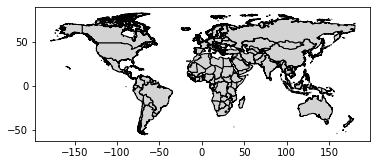

In [293]:
countries.plot(edgecolor='k', facecolor='lightgrey')

Reprojecting geometries in the GeoDataFrame:

In [294]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

<GeoAxesSubplot:>

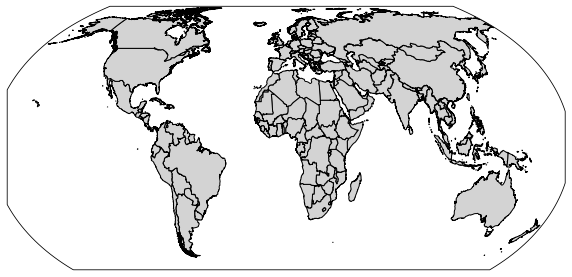

In [295]:
crs = ccrs.EqualEarth()

fig = plt.figure(figsize=(10,5))

ax = plt.axes(projection=crs)

countries.to_crs(crs.proj4_init).plot(ax=ax, edgecolor='k', facecolor='lightgrey')

## Raster Data with `rasterio`

But we haven't worked with **raster data** yet!

One useful package for working with raster data is `rasterio`:

In [296]:
import rasterio

With rasterio, we can for instance load GeoTIFF files.

In the example below, we load the CORINE land cover classification for Portugal:

https://land.copernicus.eu/pan-european/corine-land-cover

In [297]:
clc = rasterio.open('../../materials/corine/U2018_CLC2018_V2020_20u1-PT.tif')

Datasets can have one or more bands (or layers), which can be read with the `.read()` function:

In [298]:
band = clc.read(1)

The returned object is a 2-dimensional `numpy.ndarray`. 

In [299]:
type(band)

numpy.ndarray

In [300]:
band.shape

(5662, 3404)

The band values correspond to a land cover and land use classification scheme with class values as listed at https://collections.sentinel-hub.com/corine-land-cover/readme.html.

This is an example of **categorical values** in raster data.

In [301]:
import numpy as np

In [302]:
np.unique(band)

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   35,   37,   38,   39,   40,   41,   42,   43,   44],
      dtype=int8)

There are two common options to plot raster data:
- with `plt.imshow()`
- with `rasterio.plot.show()`

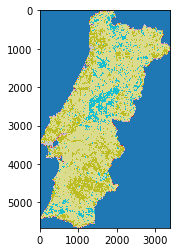

In [303]:
plt.imshow(band, cmap='tab20')

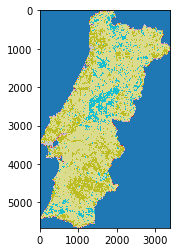

<AxesSubplot:>

In [304]:
from rasterio.plot import show
show(band, cmap='tab20')

The integrated `rasterio` plotting functionality is slightly more powerful.

For instance, it can label the axes with proper geo-referenced extents.

These are stored in the `.crs`, `.bounds` and `.transform` attributes.

In [305]:
clc.crs

CRS.from_epsg(3035)

In [306]:
clc.bounds

BoundingBox(left=2635400.0, bottom=1732500.0, right=2975800.0, top=2298700.0)

In [307]:
clc.transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can pass the information on the projection to the `rasterio.plot.show()` function:

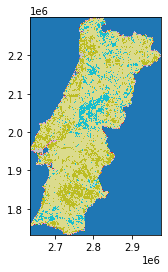

<AxesSubplot:>

In [308]:
from rasterio.plot import show
show(band, transform=clc.transform, cmap='tab20')

Let's quickly load another dataset with **continuous values**: The elevation and water depth in and around Portugal.

This dataset comes from [GEBCO Gridded Bathymetry Data](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) and has another file format `.nc` (netCDF) which also stores raster data.

In [309]:
gebco = rasterio.open('../../materials/gebco/GEBCO_2014_2D-PT.nc')

In [310]:
band = gebco.read(1)

In [311]:
np.unique(band)

array([-2898, -2862, -2856, ...,  1915,  1926,  1959], dtype=int16)

For plotting, we can also display **vector and raster data together**:

<AxesSubplot:>

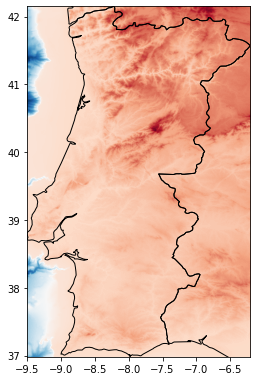

In [312]:
fig, ax = plt.subplots(figsize=(4,8))
countries.loc[["PT", "ES"]].plot(ax=ax, color='none')
show(band, transform=gebco.transform, cmap='RdBu_r', ax=ax)

## Land Eligibility Analysis with `atlite`

To estimate the wind and solar generation potential of a country, land usage constraints need to be taken into account.

Data required to determine the eligible areas is stored as **raster** and **vector** data.

**Examples:**

- **Vector Data:** natural protection areas, settlements
- **Raster Data:** roads, airports, type of land, elevation, slope

The `atlite` library has some useful features to handle exclusion constraints for both datatypes.

The core object to do land elibility analysis in `atlite` is the `ExclusionContainer`, which serves as a container for all rasters and geometries we want to exclude (or possibly include).

In [313]:
from atlite.gis import ExclusionContainer

In many cases, rasters and geometries have different projections and resolutions. Therefore, the `ExclusionContainer` is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is 3035 and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this CRS and resolution.

In [314]:
excluder = ExclusionContainer(crs=3035)

Let's add our first exclusion criteria, the Natura2000 natural protection areas, to the container using the `excluder.add_geometry()` function. This function is for vector data. It's sibling, `excluder.add_raster()` we will use later.

In [315]:
excluder.add_geometry('../../materials/natura/Natura2000_end2021-PT.gpkg')

To calculate the *mask* for the exclusion container (i.e. which cells are not excluded), we can use the `shape_availability()` function, which takes as arguments:
- a **geometry** (e.g. country shape) within which to calculate available areas
- an **exclusion container** object

In [316]:
from atlite.gis import shape_availability

Since the excluder is in `crs=3035`, we should also convert to geometry of Portucal to `excluder.crs` first.

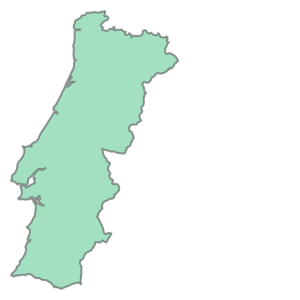

In [317]:
shape = countries.to_crs(excluder.crs).loc[["PT"]].geometry
shape[0]

We can then call the `shape_availability` function:

In [318]:
band, transform = shape_availability(shape, excluder)

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/atlite/gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


This function returns a 2-D `numpy.ndarray` and a transformation, similar to the previous `rasterio` examples.

Eligile raster cells have a `True` and excluded cells a `False`.

In [319]:
band

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [320]:
band.any()

True

In [321]:
transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can use th `rasterio.plot.show()` function for plotting:

<AxesSubplot:>

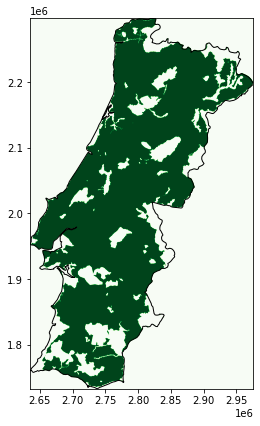

In [322]:
fig, ax = plt.subplots(figsize=(4,8))
shape.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

How to calculate what share of the land is eligible?
1. count number of eligible raster cells
2. determine area per raster cell
3. multiply cell area with number of cells
4. divide eligible area by total land area

In [323]:
eligible_cells = band.sum()

In [324]:
cell_area = excluder.res**2

In [325]:
eligible_area = cell_area * eligible_cells

In [326]:
country_area = shape.geometry.area[0]

In [327]:
eligible_area / country_area * 100 

79.65002907506357

In this example, approximately 20% of Portugal's land area are covered by nature reserves.

Typically, more than one dataset is needed for a proper land eligibility analysis, i.e. we need to add more datasets to our container.
So, let's expand the exclusion container ...

In [328]:
excluder = ExclusionContainer()
excluder.add_geometry('../../materials/natura/Natura2000_end2021-PT.gpkg')

... by a selection of CORINE land cover classes, which is given as raster data:

When adding a raster to the `ExclusionContainer` you can specify which **codes** (integers) to exclude.

By setting `invert=True`, you can also restrict the inclusion to a set of codes.

Furthermore, you can add a buffer around codes which should also be excluded.

Here we are first going to include a set of suitable [CORINE classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html):

In [329]:
codes = [12, 13, 18, 19, 20, 21]

In [330]:
fn = '../../materials/corine/U2018_CLC2018_V2020_20u1-PT.tif'

In [333]:
excluder.add_raster(fn, codes=codes, crs=3035, invert=True)

And then we are going exclude [CORINE classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html) representing settled areas with an 800 meter buffer around them:

In [334]:
fn = '../../materials/corine/U2018_CLC2018_V2020_20u1-PT.tif'

In [335]:
codes = [1, 2, 3, 4, 5, 6]

In [335]:
excluder.add_raster(fn, codes=codes, buffer=800, crs=3035)

Then, we can simply repeat the calculation and visualisation of available cells:

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/atlite/gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


<AxesSubplot:>

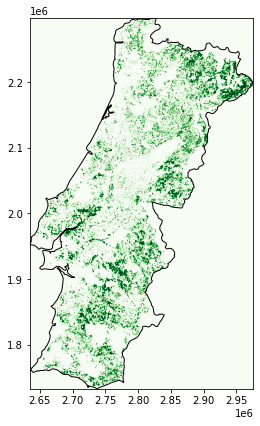

In [336]:
band, transform = shape_availability(shape, excluder)

fig, ax = plt.subplots(figsize=(4,8))
shape.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

## Combined Spatial and Temporal Availability

## Exercise

Tweak some parameters of the land exclusion calculation:

- vary the CORINE land classes allower for wind turbine development
- vary the buffer distance and observe the change in availble area
- add the GEBCO topography data to the exclusion calculator and exclude areas above 1000 m